# End-to-End Machine Learning Project

### Background

You are a recently hired data scientist at a real estate company (Machine Learning Housing Corporation).

### Frame the Problem

##### __Objectives__
You are asked to build a model of housing prices in California using the California census data. The model's output  (prediction of a district's median housing price) will be used downstream in another Machine Learning system.

##### __Current Solution__
The prices are currently estimated manually by experts which is time-consuming with estimates off by over 10%. RMSE and MAPE may then be the best error metrics to use.

##### __Check the Assumptions__
It has been confirmed that the downstream system wants a numeric prediction and not a category (e.g. low, medium, high).

### Get the Data

Create a function to obtain the data. This is useful for if the data changes regularly so that this process can be automated via a script.

In [6]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH  = "datasets/housing"
HOUSING_URL   = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    """
    Get data from URL and unzip in the path folder
    """
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [7]:
fetch_housing_data()

Create function to load the data and return a pandas dataframe. 

In [11]:
import pandas as pd

HOUSING_PATH  = "datasets/housing"

def load_housing_data(housing_path = HOUSING_PATH):
    """
    Load data from folder
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

In [10]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [14]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


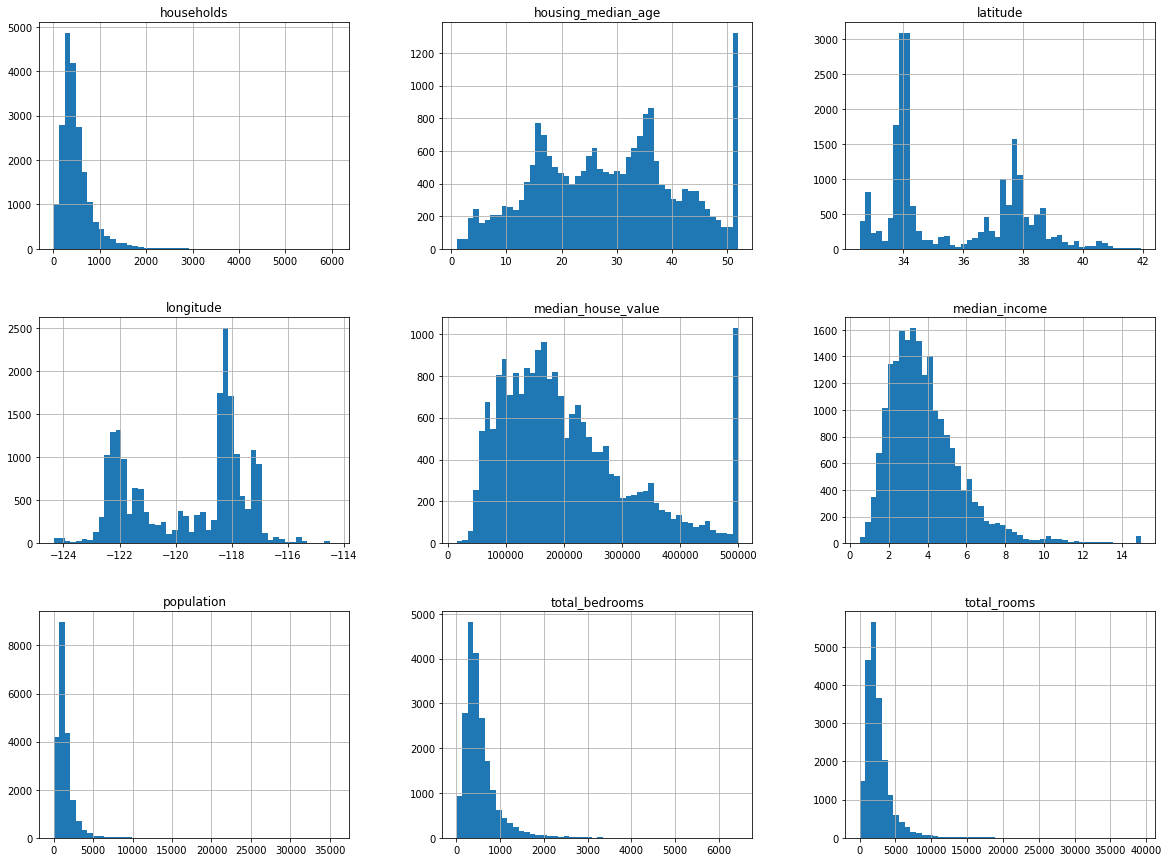

In [16]:
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

##### __Notes__

+ Median income not in USD. Variable has been scaled previously and capped at 15.0001 for high median incomes and 0.49 for low median incomes. Should try to understand how this was computed for future values and interpretation. 

+ Housing median age and median house value have also been capped. This may be an issue as we are attempting to predict on the median house value. Model may learn that values never exceed 500k. There are two options:

    + Collect proper labls for districts with capped labels
    + Remove districts with capped labels from the training and test sets since model may have poor prediction ability beyond 500k

In [18]:
# standard train/test split with no stratification
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [20]:
# create stratified sample based on median income (experts say this is important predictor)
# first create categorical variable to pass into stratifed splitter

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

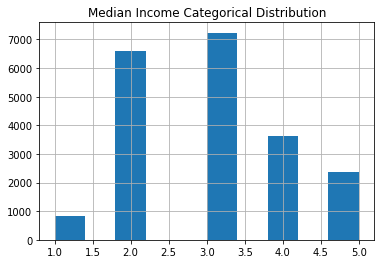

In [30]:
housing["income_cat"].hist()
plt.title("Median Income Categorical Distribution")
plt.show()

In [25]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]

In [26]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [27]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [28]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [29]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

In [31]:
housing = strat_train_set.copy()

In [39]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


### Discover and Visualize the Data to Gain Insights

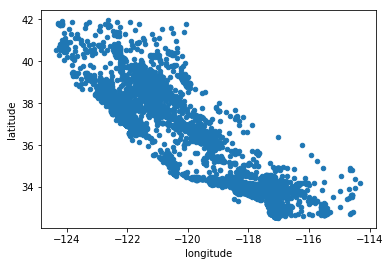

In [34]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")
plt.show()

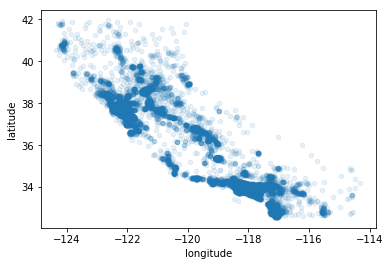

In [35]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)
plt.show()

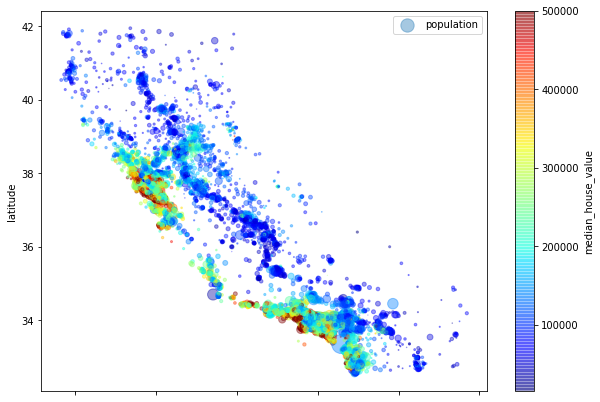

In [51]:
housing.plot(
    kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, 
    s = housing["population"] / 100, label = "population", figsize = (10,7),
    c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True
)
plt.legend()
plt.show()

In [52]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64